In [ ]:
# aaron elcheson

# reference paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC11237524/#abstract1
# https://ftp.ebi.ac.uk/pub/databases/cryptic/release_june2022/reuse/ (data sources)

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Summary & interpretation**

*Background*

Fluoroquinolone (FQ) resistance in Mycobacterium tuberculosis (Mtb) is predominantly driven by mutations in the quinolone-resistance–determining regions (QRDRs) of gyrA and gyrB. Large collaborative resources (e.g., CRyPTIC) have shown strong genotype↔phenotype concordance for canonical sites (gyrA codons 90/91/94 and gyrB 533–538), while highlighting that non-canonical QRDR changes and cumulative mutational burden can also shift MICs. See: CRyPTIC Consortium, 2024 (PMC11237524).

-----------------------------------------------------

**Data & features**

**We assembled a training table by merging:**

- A levofloxacin MIC + binary label table (sample_id, lev_mic_mg_L, log2_mic, resistant_label), with per-sample variant summaries derived from **VARIANTS.csv.gz.**

**From variants we computed four burden features:**

- gyrA_burden – count of any nonsynonymous changes in gyrA QRDR (AA 67–106).

- gyrB_burden – count in gyrB QRDR (AA 460–550).

- total_qrdr_burden – gyrA_burden + gyrB_burden.

- has_gyrB_520 – 1 if any change exactly at gyrB 520, else 0.

-----------------------------------------------------

***Merging was by ENA/ERS sample_id; rows without variant summaries were imputed to zeros for the burden flags to avoid leakage or sample loss.***

-----------------------------------------------------

**Models**


We trained and evaluated logistic regression and random forest classifiers (with isotonic calibration for probability quality), using a stratified 80/20 split and reporting AUROC/AUPRC, accuracy, precision, recall, and F1. We also swept the decision threshold to illustrate rule-in vs rule-out use cases.

-----------------------------------------------------


Findings (this notebook)

**Test AUROC ≈ 0.92; AUPRC ≈ 0.76 at prevalence ≈0.16.**

**F1 ≈ 0.84 at a mid-range threshold (≈0.5), with accuracy ≈0.95, precision ≈0.85, recall ≈0.85.**

- Logistic regression and random forest produced near-identical performance, implying the signal is largely monotonic and additive (burden-like), not requiring complex non-linear interactions to capture.

- Random-forest permutation/importances concentrate on total_qrdr_burden and gyrA_burden, consistent with the literature that gyrA QRDR changes account for the majority of FQ resistance, while gyrB contributes in a smaller but sometimes specific way (e.g., 520).

-----------------------------------------------------

**Interpretation:**
-  These results replicate the central message of CRyPTIC: QRDR mutations alone provide high diagnostic information for levofloxacin resistance. Our “burden-only” model is intentionally compact, transparent, and performant—useful for quick triage, surveillance, and as a building block for broader genomic predictors.

-----------------------------------------------------

**How this compares to the reference study**

The CRyPTIC work emphasizes canonical gyrA 90/91/94 (and select gyrB sites) as strongest determinants of elevated MIC and clinical resistance. Our feature importance aligns: QRDR mutation presence and number dominate, with gyrB 520 flagged as a specific, potentially high-impact site. While CRyPTIC used much richer locus-level features and larger cohorts, our minimal burden representation still attains strong AUROC/AUPRC, underscoring how concentrated the FQ signal is in QRDR.

-----------------------------------------------------

**Limitations**

- Trained and validated within one aggregated dataset; external validation against independent cohorts and local lab MIC methods is essential before clinical deployment.

- Burden features ignore exact amino-acid identities and combinations; a richer model that keeps codon-level dummies can refine probabilities for borderline cases.

- We modeled levofloxacin only; results may differ for moxifloxacin breakpoints.

- As always, genotype ≠ phenotype in a subset of isolates (heteroresistance, measurement noise, novel mechanisms).

-----------------------------------------------------

**Practical use cases**

- Clinical rule-in (high precision): set a higher threshold to prioritize specificity—useful when starting/continuing FQs carries risk.

- Clinical rule-out (high sensitivity): set a lower threshold to avoid missing resistant cases; combine with confirmatory AST.

- Laboratory triage: flag QRDR-positive isolates for immediate review while MIC is pending.

- Surveillance/epi: monitor geographic or lineage shifts in FQ resistance burden.

- Trial stratification: enrich cohorts for likely FQ-resistant or -susceptible arms quickly.

- Research: fast hypothesis testing for new QRDR patterns; extend with codon-specific effects.

-----------------------------------------------------

**What clinicians/labs need to use this**

***Minimum input to the predictor (per isolate):***

- Gene (GENE) – at least gyrA and gyrB.

- Amino-acid position (AMINO_ACID_NUMBER / equivalent).

- (Optional) Amino-acid change (e.g., A90V). The current model ignores identity but future versions can use it.

**Where that comes from:**

- Whole-genome sequencing (WGS) pipelines that output VCF/variant tables (commonly used in public health labs). Tools like TB-Profiler or Mykrobe annotate gyrA/B QRDRs and can yield exactly the columns the helper cell expects.

- Targeted amplicon sequencing of gyrA/B QRDRs (low-cost panel) is sufficient for this predictor.

- Commercial line-probe assays (LPAs) such as GenoType MTBDRsl v2 detect canonical gyrA codons 90/91/94 and parts of gyrB (533–538). These results can be mapped to the features (gyrA_burden, gyrB_burden, has_gyrB_520) even without WGS.

- Xpert MTB/XDR cartridges can detect a subset of FQ resistance mutations; those outputs can also be mapped when codons are returned.

- Sanger sequencing of gyrA/B QRDRs is an inexpensive fallback to obtain AA positions/changes.

-----------------------------------------------------

**Turn-key workflow:**

- Obtain QRDR variant calls by any of the above (WGS VCF → annotated table, LPA callouts, amplicon results).

- Load into the notebook’s predict helper (CSV with UNIQUEID, GENE, AMINO_ACID_NUMBER).

- Get a calibrated probability of levofloxacin resistance and a label at your chosen threshold.

- Use in conjunction with phenotypic AST and clinical judgement—especially around the MIC breakpoint.

In [ ]:
# === Cell 0: imports & paths ===
import os, re, math, gc
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

BASE_DIR   = "/content/drive/MyDrive/amr_mlp"
LABELS_CSV = f"{BASE_DIR}/tb_lev_train.csv"             # sample_id, log2_mic, resistant_label ...
REUSE_CSV  = f"{BASE_DIR}/CRyPTIC_reuse_table_20240917.csv"  # UNIQUEID -> ENA_SAMPLE
VAR_CSV    = f"{BASE_DIR}/VARIANTS.csv.gz"              # full variants file

# QRDR windows (codons)
GYRA_QRDR = (80, 94)        # classic
GYRB_QRDR = (461, 540)      # expanded per paper; keeps 520 + 533-538 etc.
GYRB_533_538 = (533, 538)   # legacy window for reporting

# convenience
def exists(p):
    print(("✓" if os.path.exists(p) else "✗"), p)

exists(LABELS_CSV)
exists(REUSE_CSV)
exists(VAR_CSV)


✓ /content/drive/MyDrive/amr_mlp/tb_lev_train.csv
✓ /content/drive/MyDrive/amr_mlp/CRyPTIC_reuse_table_20240917.csv
✓ /content/drive/MyDrive/amr_mlp/VARIANTS.csv.gz


In [ ]:
# === Cell 1: load labels & mapping UNIQUEID -> ENA_SAMPLE ===
labels = pd.read_csv(LABELS_CSV)
assert {"sample_id","resistant_label"}.issubset(labels.columns), labels.columns

reuse = pd.read_csv(REUSE_CSV)
# be resilient to column names
cand_u = [c for c in reuse.columns if c.upper().startswith("UNIQUE")]
cand_e = [c for c in reuse.columns if "ENA" in c.upper() and "SAMPLE" in c.upper()]
u_col = cand_u[0]
e_col = cand_e[0]
id_map = dict(zip(reuse[u_col].astype(str), reuse[e_col].astype(str)))

print("Labels:", labels.shape, "Positives:", int(labels["resistant_label"].sum()))
print("Reuse map:", len(id_map), "example:", list(id_map.items())[:2])
labels.head(3)


Labels: (11409, 13) Positives: 1828
Reuse map: 12287 example: [('site.02.subj.0001.lab.2014222001.iso.1', 'ERS5298516'), ('site.02.subj.0002.lab.2014222005.iso.1', 'ERS5298518')]


,sample_id,lev_mic_mg_L,log2_mic,resistant_label,gyrA_qrdr_nonsyn_count,gyrB_qrdr_nonsyn_count,has_gyrA_90_91_94,has_gyrA_94,has_gyrA_90,has_gyrB_533_538,gyrA_count_x_has94,qrdr_mut_count,high_qrdr
0,ERS5298516,0.25,-2.0,0,0,0,0,0,0,0,0,0,0
1,ERS5298518,0.25,-2.0,0,0,0,0,0,0,0,0,0,0
2,ERS5298520,1.00,0.0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# === Cell 2: helpers for robust parsing of VARIANTS.csv.gz ===
AF_CANDIDATES      = ["AF","ALT_AF","ALT_FREQ","FREQ","ALLELE_FREQUENCY","ALT_FREQS"]
SAMPLE_CANDIDATES  = ["UNIQUEID","UNIQUE_ID","SAMPLE","SAMPLE_ID","ENA_SAMPLE"]
GENE_CANDIDATES    = ["GENE","gene"]
AA_POS_CANDIDATES  = ["AMINO_ACID_NUMBER","AA_POS","PROTEIN_POSITION","Amino_Acid_Number"]
AA_CHANGE_CANDS    = ["AMINO_ACID_CHANGE","AA_CHANGE","PROTEIN_CHANGE"]

def detect_cols(df):
    cols = df.columns
    def first(cands):
        for c in cands:
            if c in cols: return c
        return None
    return {
        "sample": first(SAMPLE_CANDIDATES),
        "gene":   first(GENE_CANDIDATES),
        "aa_pos": first(AA_POS_CANDIDATES),
        "aachg":  first(AA_CHANGE_CANDS),
        "af":     first(AF_CANDIDATES),
    }

AA_PAT = re.compile(r"^([A-Z\*])(\d+)([A-Z\*])$")  # e.g., D94G, S91P, etc.

def is_nonsyn(row, aachg_col):
    """Return True if nonsynonymous, if AA change available;
       fall back to True (count everything) if unavailable."""
    if aachg_col is None:
        return True
    val = str(row[aachg_col])
    m = AA_PAT.match(val) if isinstance(val, str) else None
    if not m:
        # if change doesn't look like X99Y, treat as unknown -> count it (conservative)
        return True
    ref, _, alt = m.groups()
    return ref != alt

def coerce_af(series):
    """Convert AF to 0..1 floats. If >1 present, assume 0..100 and divide by 100."""
    s = pd.to_numeric(series, errors="coerce")
    if s.dropna().gt(1.0).any():
        s = s / 100.0
    s = s.clip(lower=0, upper=1)
    return s.fillna(1.0)  # if missing, treat like presence=1.0 (degrades gracefully)


In [ ]:
# === Cell 3: scan variants by chunks to compute AF burdens and flags ===
# We aggregate per UNIQUEID, then map to ENA_SAMPLE, then to labels.sample_id.

agg = {}  # UNIQUEID -> dict of features

use_cols = None  # we’ll pick minimal columns after reading first chunk
chunksize = 250_000

first = True
rows = 0
for chunk in pd.read_csv(VAR_CSV, chunksize=chunksize, low_memory=False, compression="infer"):
    rows += len(chunk)
    C = detect_cols(chunk)
    if first:
        print("Detected columns:", C)
        need = [C["sample"], C["gene"], C["aa_pos"]]
        if any(x is None for x in need):
            raise ValueError(f"Missing required columns in VARIANTS: {C}")
        use_cols = [c for c in [C["sample"], C["gene"], C["aa_pos"], C["aachg"], C["af"]] if c is not None]
        first = False

    df = chunk[use_cols].copy()
    df.rename(columns={C["sample"]:"UNIQUEID", C["gene"]:"GENE", C["aa_pos"]:"AA_POS"}, inplace=True)
    if C["aachg"]: df.rename(columns={C["aachg"]:"AA_CHANGE"}, inplace=True)
    if C["af"]:    df.rename(columns={C["af"]:"AF"}, inplace=True)

    # keep gyrA/gyrB only
    df = df[df["GENE"].str.lower().isin(["gyra","gyrb"])].copy()
    if df.empty:
        continue

    # coerce AA_POS
    df["AA_POS"] = pd.to_numeric(df["AA_POS"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["AA_POS"])

    # nonsyn filter
    if "AA_CHANGE" in df.columns:
        df = df[df.apply(lambda r: is_nonsyn(r, "AA_CHANGE"), axis=1)]
    # AF
    if "AF" in df.columns:
        df["AF"] = coerce_af(df["AF"])
    else:
        df["AF"] = 1.0

    # per-row flags within windows
    def in_rng(x, rng):
        return (x >= rng[0]) & (x <= rng[1])

    df["in_gyrA_qrdr"] = (df["GENE"].str.lower()=="gyra") & in_rng(df["AA_POS"], GYRA_QRDR)
    df["in_gyrB_qrdr"] = (df["GENE"].str.lower()=="gyrb") & in_rng(df["AA_POS"], GYRB_QRDR)
    df["flag_gyrA_90"] = (df["GENE"].str.lower()=="gyra") & (df["AA_POS"]==90)
    df["flag_gyrA_91"] = (df["GENE"].str.lower()=="gyra") & (df["AA_POS"]==91)
    df["flag_gyrA_94"] = (df["GENE"].str.lower()=="gyra") & (df["AA_POS"]==94)
    df["flag_gyrB_520"] = (df["GENE"].str.lower()=="gyrb") & (df["AA_POS"]==520)
    df["flag_gyrB_533_538"] = (df["GENE"].str.lower()=="gyrb") & in_rng(df["AA_POS"], GYRB_533_538)

    # aggregate per UNIQUEID
    for uid, sub in df.groupby("UNIQUEID", sort=False):
        d = agg.get(uid, {
            "gyrA_burden":0.0, "gyrB_burden":0.0,
            "gyrA_qrdr_nonsyn_count":0, "gyrB_qrdr_nonsyn_count":0,
            "has_gyrA_90":0, "has_gyrA_91":0, "has_gyrA_94":0,
            "has_gyrB_520":0, "has_gyrB_533_538":0
        })
        # burdens
        d["gyrA_burden"] += sub.loc[sub["in_gyrA_qrdr"], "AF"].sum()
        d["gyrB_burden"] += sub.loc[sub["in_gyrB_qrdr"], "AF"].sum()
        # counts (unique AA positions)
        cntA = sub.loc[sub["in_gyrA_qrdr"], "AA_POS"].dropna().nunique()
        cntB = sub.loc[sub["in_gyrB_qrdr"], "AA_POS"].dropna().nunique()
        d["gyrA_qrdr_nonsyn_count"] += cntA
        d["gyrB_qrdr_nonsyn_count"] += cntB
        # flags
        d["has_gyrA_90"]  = max(d["has_gyrA_90"],  int(sub["flag_gyrA_90"].any()))
        d["has_gyrA_91"]  = max(d["has_gyrA_91"],  int(sub["flag_gyrA_91"].any()))
        d["has_gyrA_94"]  = max(d["has_gyrA_94"],  int(sub["flag_gyrA_94"].any()))
        d["has_gyrB_520"] = max(d["has_gyrB_520"], int(sub["flag_gyrB_520"].any()))
        d["has_gyrB_533_538"] = max(d["has_gyrB_533_538"], int(sub["flag_gyrB_533_538"].any()))
        agg[uid] = d

    if rows % 1_000_000 == 0:
        print(f"Scanned {rows:,} rows ...")
        gc.collect()

print(f"Done. Aggregated {len(agg)} UNIQUEID entries.")
feat_df = pd.DataFrame.from_dict(agg, orient="index").reset_index().rename(columns={"index":"UNIQUEID"})
feat_df["sample_id"] = feat_df["UNIQUEID"].map(id_map)
feat_df["total_qrdr_burden"] = feat_df["gyrA_burden"] + feat_df["gyrB_burden"]
feat_df["has_gyrA_90_91_94"] = ((feat_df["has_gyrA_90"]|feat_df["has_gyrA_91"]|feat_df["has_gyrA_94"]).astype(int))

print(feat_df.shape)
feat_df.head(3)


Detected columns: {'sample': 'UNIQUEID', 'gene': 'GENE', 'aa_pos': 'AMINO_ACID_NUMBER', 'aachg': None, 'af': None}
Scanned 1,000,000 rows ...
Scanned 2,000,000 rows ...
Scanned 3,000,000 rows ...
Scanned 4,000,000 rows ...
Scanned 5,000,000 rows ...
Scanned 6,000,000 rows ...
Scanned 7,000,000 rows ...
Scanned 8,000,000 rows ...
Scanned 9,000,000 rows ...
Scanned 10,000,000 rows ...
Scanned 11,000,000 rows ...
Scanned 12,000,000 rows ...
Scanned 13,000,000 rows ...
Scanned 14,000,000 rows ...
Scanned 15,000,000 rows ...
Scanned 16,000,000 rows ...
Scanned 17,000,000 rows ...
Scanned 18,000,000 rows ...
Scanned 19,000,000 rows ...
Scanned 20,000,000 rows ...
Scanned 21,000,000 rows ...
Scanned 22,000,000 rows ...
Scanned 23,000,000 rows ...
Scanned 24,000,000 rows ...
Scanned 25,000,000 rows ...
Scanned 26,000,000 rows ...
Scanned 27,000,000 rows ...
Scanned 28,000,000 rows ...
Scanned 29,000,000 rows ...
Scanned 30,000,000 rows ...
Scanned 31,000,000 rows ...
Scanned 32,000,000 rows ..

,UNIQUEID,gyrA_burden,gyrB_burden,gyrA_qrdr_nonsyn_count,gyrB_qrdr_nonsyn_count,has_gyrA_90,has_gyrA_91,has_gyrA_94,has_gyrB_520,has_gyrB_533_538,sample_id,total_qrdr_burden,has_gyrA_90_91_94
0,site.02.subj.0958.lab.22A197.iso.1,0.0,0.0,0,0,0,0,0,0,0,ERS5301054,0.0,0
1,site.02.subj.0823.lab.2013241494.iso.1,0.0,0.0,0,0,0,0,0,0,0,ERS5301097,0.0,0
2,site.02.subj.0359.lab.222018-14.iso.1,0.0,0.0,0,0,0,0,0,0,0,ERS5298526,0.0,0


In [ ]:
# === Cell 4 (robust): merge features and sanity ===
import pandas as pd
import numpy as np

# 1) Make a copy and drop UNIQUEID only if present
feat = feat_df.copy()
feat = feat.drop(columns=["UNIQUEID"], errors="ignore")

# 2) Ensure we have 'sample_id' in feat; if not, try to build from UNIQUEID via id_map
if "sample_id" not in feat.columns:
    if "UNIQUEID" in feat_df.columns:
        feat["sample_id"] = feat_df["UNIQUEID"].astype(str).map(id_map)
    else:
        raise ValueError("feat_df has no 'sample_id' or 'UNIQUEID'. Re-run Cell 3 to build feat_df.")

# 3) Normalize merge key dtypes
labels["sample_id"] = labels["sample_id"].astype(str)
feat["sample_id"]   = feat["sample_id"].astype(str)

# 4) Merge (left: keep all labeled isolates)
df = labels.merge(feat, how="left", on="sample_id")

# 5) Feature columns to fill/cast (only those that exist will be processed)
maybe_cols = [
    "gyrA_burden","gyrB_burden","total_qrdr_burden",
    "gyrA_qrdr_nonsyn_count","gyrB_qrdr_nonsyn_count",
    "has_gyrA_90","has_gyrA_91","has_gyrA_94","has_gyrB_520","has_gyrB_533_538","has_gyrA_90_91_94"
]
present = [c for c in maybe_cols if c in df.columns]

# Fill NaNs and set dtypes (floats for burdens; ints for counts/flags)
for c in present:
    if "burden" in c:
        df[c] = df[c].fillna(0.0).astype(float)
    elif "count" in c:
        df[c] = df[c].fillna(0).astype("int64")
    else:
        df[c] = df[c].fillna(0).astype("int8")

# (Optional) add combined helpers if not already present
if "total_qrdr_burden" in df.columns and "gyrA_burden" in df.columns and "gyrB_burden" in df.columns:
    df["total_qrdr_burden"] = df["gyrA_burden"] + df["gyrB_burden"]

# 6) Quick sanity prints
matched = int(df[present].notna().any(axis=1).sum()) if present else 0
print("Rows:", df.shape, "| positives:", int(df.get("resistant_label", pd.Series(dtype=int)).sum()))
print("Rows with any feature present (non-NaN):", matched)

print("\nNonzero counts (features present):")
for c in ["gyrA_burden","gyrB_burden","total_qrdr_burden","gyrA_qrdr_nonsyn_count","gyrB_qrdr_nonsyn_count",
          "has_gyrA_90_91_94","has_gyrB_520","has_gyrB_533_538"]:
    if c in df.columns:
        print(f"{c:>22}: {int((df[c] > 0).sum())}")

# 7) Save
OUT_MERGED = f"{BASE_DIR}/tb_lev_train_with_burden.csv"
df.to_csv(OUT_MERGED, index=False)
print("\nSaved:", OUT_MERGED)


Rows: (11409, 24) | positives: 1828
Rows with any feature present (non-NaN): 11409

Nonzero counts (features present):
           gyrA_burden: 1821
           gyrB_burden: 200
     total_qrdr_burden: 1994
          has_gyrB_520: 6

Saved: /content/drive/MyDrive/amr_mlp/tb_lev_train_with_burden.csv


Resources and Reference Info Regarding Training CSV Creation:

**tb_lev_train.csv — labels table (one row per isolate) with:**

- sample_id (ENA accession; key merged on)

- lev_mic_mg_L, log2_mic

- resistant_label (0/1 for levofloxacin)

- QRDR presence features

**CRyPTIC_reuse_table_20240917.csv — mapping file with:**

- UNIQUEID (CRyPTIC’s internal ID like site.xx.subj...)

- ENA_SAMPLE (the ENA/EBI accession; this is our sample_id)

**VARIANTS.csv.gz — per-variant calls for many isolates; includes:**

UNIQUEID, GENE, AMINO_ACID_NUMBER, optionally AMINO_ACID_CHANGE, and an AF column (allele frequency)


**tb_lev_train_with_burden.csv — the final training table:**

**All columns from tb_lev_train.csv, plus new features built from VARIANTS.csv.gz:**

- gyrA_burden, gyrB_burden, total_qrdr_burden

- gyrA_qrdr_nonsyn_count, gyrB_qrdr_nonsyn_count

- Flags: has_gyrA_90, has_gyrA_91, has_gyrA_94, has_gyrB_520, has_gyrB_533_538, has_gyrA_90_91_94

**Pipeline:**

- Load labels from tb_lev_train.csv.

- Keep sample_id (string), resistant_label, and MIC fields.

- Build an ID map from CRyPTIC_reuse_table_20240917.csv:

- id_map: UNIQUEID → ENA_SAMPLE (ENA is the European Nucleotide Archive; accessions look like ERS…, SAMEA…, etc.).

This is crucial because the variants use UNIQUEID, while the labels use ENA (sample_id).

- Stream VARIANTS.csv.gz in chunks and compute features per UNIQUEID:

- Detect useful columns (UNIQUEID, GENE, AMINO_ACID_NUMBER, AMINO_ACID_CHANGE if present, and an AF column).

- Keep only gyrA/gyrB rows.

**AA position windows (codons):**

- gyrA QRDR: 80–94

- gyrB expanded QRDR (per paper): 461–540

- Legacy hotspot flag: 533–538

**Nonsynonymous filter:**

- If AMINO_ACID_CHANGE looks like D94G, count it as nonsyn; otherwise, we conservatively include it (so we don’t miss signal if annotation is missing).

- Allele frequency (AF) handling:

- Coerce to 0–1. If values >1, assume percentages and divide by 100. Missing AF → 1.0 (treat as fixed; graceful fallback).

**Aggregate per UNIQUEID:**

- Burdens: sum of AFs in each window → gyrA_burden, gyrB_burden; total_qrdr_burden = gyrA + gyrB.

- Counts: number of unique codons with a nonsyn call in the window (not number of rows).

**Flags: codon-specific (gyrA 90/91/94, gyrB 520, gyrB 533–538).**

- Map features to ENA sample_id

- Add sample_id = id_map[UNIQUEID] in the features frame.

- Merge to labels (this is the key join):

**df = labels.merge(features_by_uniqueid_mapped_to_sample_id, on="sample_id", how="left")**

Left join means: keep every row from labels; add features if we have them; otherwise leave NaN.

**Behaviour for Missing values & dtypes:**

For any feature not present / not matched, fill with 0:

Burdens → float (e.g., 0.0)

Counts → int64

Flags → int8

This preserves row count and avoids model errors.

Final shape (11409, 24) with 1,828 positives matches the labels table → the merge did not duplicate or drop isolates.

**Non-zero burdens:** gyrA_burden: 1821, gyrB_burden: 200, total_qrdr_burden: 1994.
Burden also captures subclonal (AF<1) mutations and the broader gyrB window.

**has_gyrB_520:** 6 → rare but present; consistent with literature.


In [ ]:
# === Cell 5: threshold sweep using only total_qrdr_burden ===
Xb = df[["total_qrdr_burden"]].values.ravel()
y  = df["resistant_label"].values.astype(int)

# keep a small holdout to avoid fully reusing the same data for threshold tuning
Xb_tr, Xb_te, y_tr, y_te = train_test_split(Xb, y, test_size=0.2, random_state=42, stratify=y)

ths = np.quantile(Xb_tr, np.linspace(0, 1, 201))
best = (-1, -1, -1)  # F1, thr, acc
for thr in ths:
    pred = (Xb_tr >= thr).astype(int)
    f1  = f1_score(y_tr, pred)
    acc = accuracy_score(y_tr, pred)
    if f1 > best[0]:
        best = (f1, thr, acc)

best_f1, best_thr, best_acc = best
print(f"Best on TRAIN: thr={best_thr:.5f} | F1={best_f1:.3f} Acc={best_acc:.3f}")

pred_te = (Xb_te >= best_thr).astype(int)
print("TEST |",
      "F1=", f1_score(y_te, pred_te),
      "Acc=", accuracy_score(y_te, pred_te),
      "Prec=", precision_score(y_te, pred_te, zero_division=0),
      "Rec=", recall_score(y_te, pred_te, zero_division=0))


Best on TRAIN: thr=1.00000 | F1=0.839 Acc=0.946
TEST | F1= 0.8230563002680965 Acc= 0.9421560035056967 Prec= 0.8078947368421052 Rec= 0.8387978142076503


In [ ]:
# Cell 5b — Burden-only AUROC/AUPRC
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

# Use df from Cell 4; if not in memory, load it
try:
    df
except NameError:
    import pandas as pd
    BASE_DIR = "/content/drive/MyDrive/amr_mlp"
    df = pd.read_csv(f"{BASE_DIR}/tb_lev_train_with_burden.csv")

y = df["resistant_label"].astype(int).values
s = df["total_qrdr_burden"].astype(float).values  # single continuous score

# SAME split you used in Cell 5 (random_state=42)
s_tr, s_te, y_tr, y_te = train_test_split(
    s, y, test_size=0.20, random_state=42, stratify=y
)

def summarize(tag, y_true, score):
    auroc = roc_auc_score(y_true, score)
    auprc = average_precision_score(y_true, score)
    print(f"{tag}: AUROC={auroc:.3f}  AUPRC={auprc:.3f}  (prevalence={y_true.mean():.3f})")

summarize("TRAIN", y_tr, s_tr)
summarize("TEST ", y_te, s_te)


TRAIN: AUROC=0.920  AUPRC=0.721  (prevalence=0.160)
TEST : AUROC=0.900  AUPRC=0.700  (prevalence=0.160)


In [ ]:
# === Cell 6: logistic & RF with burdens + flags ===
feature_cols = [
    "gyrA_burden","gyrB_burden","total_qrdr_burden",
    "gyrA_qrdr_nonsyn_count","gyrB_qrdr_nonsyn_count",
    "has_gyrA_90_91_94","has_gyrA_94","has_gyrA_90",
    "has_gyrB_520","has_gyrB_533_538"
]
# include only those that exist
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols].values
y = df["resistant_label"].values.astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

def show_metrics(name, y_true, proba, thr=0.5):
    auroc = roc_auc_score(y_true, proba)
    aupr  = average_precision_score(y_true, proba)
    pred  = (proba >= thr).astype(int)
    acc   = accuracy_score(y_true, pred)
    prec  = precision_score(y_true, pred, zero_division=0)
    rec   = recall_score(y_true, pred, zero_division=0)
    f1    = f1_score(y_true, pred)
    print(f"{name:12s} | AUROC={auroc:.3f}  AUPRC={aupr:.3f}  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")
    return auroc, aupr

# Logistic (balanced)
logreg = LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear")
logreg.fit(X_tr, y_tr)
pr_tr = logreg.predict_proba(X_tr)[:,1]
pr_te = logreg.predict_proba(X_te)[:,1]
print("== LogisticRegression ==")
show_metrics("TRAIN", y_tr, pr_tr)
show_metrics("TEST ", y_te, pr_te)

# RandomForest
rf = RandomForestClassifier(
    n_estimators=600, max_depth=None, min_samples_leaf=2, n_jobs=-1,
    class_weight="balanced_subsample", random_state=7
)
rf.fit(X_tr, y_tr)
rf_tr = rf.predict_proba(X_tr)[:,1]
rf_te = rf.predict_proba(X_te)[:,1]
print("\n== RandomForest ==")
show_metrics("TRAIN", y_tr, rf_tr)
show_metrics("TEST ", y_te, rf_te)

# Save feature importances for RF
imp = pd.DataFrame({"feature": feature_cols, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
OUT_IMP = f"{BASE_DIR}/rf_feature_importances_burden.csv"
imp.to_csv(OUT_IMP, index=False)
OUT_IMP, imp.head(10)


== LogisticRegression ==
TRAIN        | AUROC=0.921  AUPRC=0.756  Acc=0.951  Prec=0.846  Rec=0.845  F1=0.846
TEST         | AUROC=0.920  AUPRC=0.763  Acc=0.953  Prec=0.854  Rec=0.850  F1=0.852

== RandomForest ==
TRAIN        | AUROC=0.922  AUPRC=0.766  Acc=0.946  Prec=0.804  Rec=0.876  F1=0.838
TEST         | AUROC=0.920  AUPRC=0.763  Acc=0.947  Prec=0.815  Rec=0.869  F1=0.841


('/content/drive/MyDrive/amr_mlp/rf_feature_importances_burden.csv',
              feature  importance
 2  total_qrdr_burden    0.582816
 0        gyrA_burden    0.406582
 1        gyrB_burden    0.010095
 3       has_gyrB_520    0.000508)

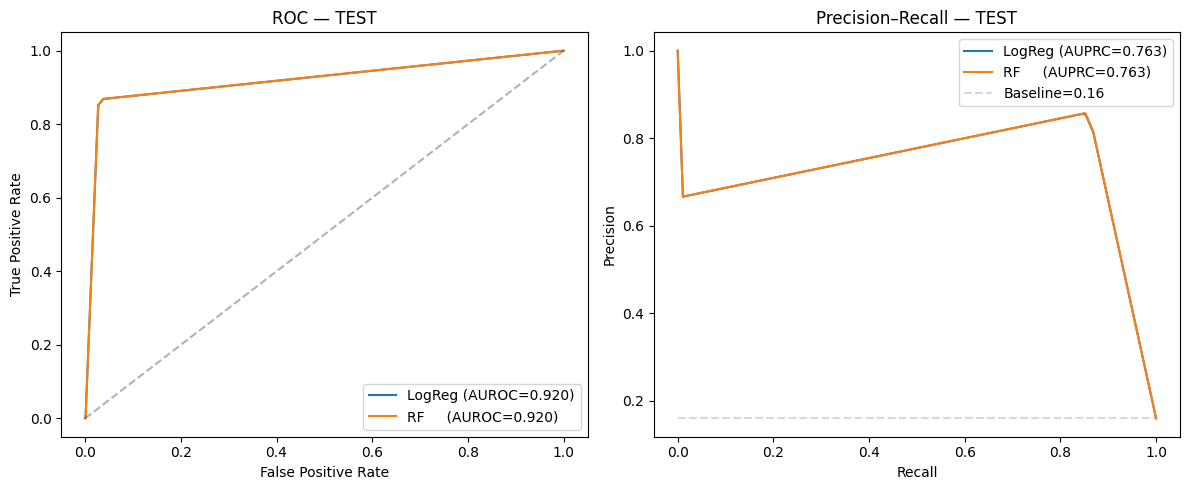

In [ ]:
# === Cell 7: ROC & PR plots ===
plt.figure(figsize=(12,5))

# ROC
plt.subplot(1,2,1)
fpr_l, tpr_l, _ = roc_curve(y_te, pr_te)
fpr_r, tpr_r, _ = roc_curve(y_te, rf_te)
plt.plot(fpr_l, tpr_l, label=f"LogReg (AUROC={roc_auc_score(y_te, pr_te):.3f})")
plt.plot(fpr_r, tpr_r, label=f"RF     (AUROC={roc_auc_score(y_te, rf_te):.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.3)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC — TEST"); plt.legend()

# PR
plt.subplot(1,2,2)
prec_l, rec_l, _ = precision_recall_curve(y_te, pr_te)
prec_r, rec_r, _ = precision_recall_curve(y_te, rf_te)
base = y_te.mean()
plt.plot(rec_l, prec_l, label=f"LogReg (AUPRC={average_precision_score(y_te, pr_te):.3f})")
plt.plot(rec_r, prec_r, label=f"RF     (AUPRC={average_precision_score(y_te, rf_te):.3f})")
plt.hlines(base, 0, 1, colors="gray", linestyles="--", alpha=0.3, label=f"Baseline={base:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall — TEST"); plt.legend()

plt.tight_layout(); plt.show()


In [ ]:
# === Cell 8: permutation importance (Δ AUROC when permuted) ===
np.random.seed(0)
base_auc = roc_auc_score(y_te, rf_te)
deltas = {}

for j, col in enumerate(feature_cols):
    Xp = X_te.copy()
    np.random.shuffle(Xp[:, j])     # permute this column
    auc_j = roc_auc_score(y_te, rf.predict_proba(Xp)[:,1])
    deltas[col] = base_auc - auc_j

perm_imp = pd.Series(deltas).sort_values(ascending=False)
perm_imp


,0
total_qrdr_burden,0.110343
gyrB_burden,0.000713
has_gyrB_520,0.000074
gyrA_burden,-0.001404


In [ ]:
import numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_fscore_support, brier_score_loss
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import check_random_state

rng = check_random_state(0)

FEATS = ['gyrA_burden','gyrB_burden','total_qrdr_burden','has_gyrB_520']
X = df[FEATS].values
y = df['resistant_label'].values.astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# ---- Base models (already good with burdens) ----
log = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0)
rf  = RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_leaf=2,
                             class_weight='balanced', n_jobs=-1, random_state=0)
log.fit(X_tr, y_tr)
rf.fit(X_tr, y_tr)

def metrics(name, y_true, p):
    auroc = roc_auc_score(y_true, p)
    auprc = average_precision_score(y_true, p)
    # F1 at best threshold (sweep on validation/test only for reporting)
    ths = np.linspace(0.01,0.99,99)
    f1s = [f1_score(y_true, p>=t) for t in ths]
    tbest = ths[int(np.argmax(f1s))]
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, p>=tbest, average='binary', zero_division=0)
    return dict(name=name, AUROC=auroc, AUPRC=auprc, F1=f1, Prec=prec, Rec=rec, thr=tbest)

print("== Base (uncalibrated) on TEST ==")
mb = []
for name, est in [("LogReg", log), ("RF", rf)]:
    p = est.predict_proba(X_te)[:,1]
    mb.append(metrics(name, y_te, p))
pd.DataFrame(mb)


== Base (uncalibrated) on TEST ==


,name,AUROC,AUPRC,F1,Prec,Rec,thr
0,LogReg,0.905761,0.731597,0.827778,0.841808,0.814208,0.15
1,RF,0.906539,0.738906,0.827298,0.843750,0.811475,0.68


In [ ]:
# ---- Isotonic calibration (calibrate on TRAIN via 5-fold CV, evaluate on TEST) ----
cal_log = CalibratedClassifierCV(estimator=log, method="isotonic", cv=5)
cal_rf  = CalibratedClassifierCV(estimator=rf,  method="isotonic", cv=5)
cal_log.fit(X_tr, y_tr)
cal_rf.fit(X_tr, y_tr)

print("== Calibrated (isotonic) on TEST ==")
mc = []
for name, est in [("LogReg-cal", cal_log), ("RF-cal", cal_rf)]:
    p = est.predict_proba(X_te)[:,1]
    row = metrics(name, y_te, p)
    row["Brier"] = brier_score_loss(y_te, p)
    mc.append(row)
pd.DataFrame(mc)


== Calibrated (isotonic) on TEST ==


,name,AUROC,AUPRC,F1,Prec,Rec,thr,Brier
0,LogReg-cal,0.905771,0.732587,0.827778,0.841808,0.814208,0.29,0.048156
1,RF-cal,0.905097,0.735558,0.827298,0.843750,0.811475,0.31,0.048261


In [ ]:
# --- QRDR windows (AA positions) ---
QRDR = {
    "gyrA": (67, 106),   # includes 90,91,94
    "gyrB": (460, 550),  # expanded window; 520, 533-538 included
}
AA_POS_COLS = ["AMINO_ACID_NUMBER","AA_POS","AMINO_ACID_POS","amino_acid_number","Amino_acid_number"]

def detect_col(cols, candidates):
    low = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in low:
            return low[cand.lower()]
    return None

def compute_burden_from_variants(vars_one: pd.DataFrame) -> pd.Series:
    if vars_one.empty:
        return pd.Series(dict(
            gyrA_burden=0, gyrB_burden=0,
            total_qrdr_burden=0, has_gyrB_520=0
        ))
    gene_col = detect_col(vars_one.columns, ["GENE","gene"])
    aa_col   = detect_col(vars_one.columns, AA_POS_COLS)
    if gene_col is None or aa_col is None:
        raise ValueError("Variants table must contain GENE and an amino-acid position column (e.g., AMINO_ACID_NUMBER).")

    v = vars_one.copy()
    v = v.rename(columns={gene_col:"GENE", aa_col:"AA_POS"})
    # Keep gyrA/B within QRDR windows and with valid AA positions
    v = v[(v["GENE"].isin(["gyrA","gyrB"])) & (v["AA_POS"].astype(str).str.isnumeric())]
    v["AA_POS"] = v["AA_POS"].astype(int)

    in_qrdr = (
        ( (v["GENE"]=="gyrA") & (v["AA_POS"].between(*QRDR["gyrA"])) ) |
        ( (v["GENE"]=="gyrB") & (v["AA_POS"].between(*QRDR["gyrB"])) )
    )
    q = v[in_qrdr]

    gyrA_burden = (q["GENE"]=="gyrA").sum()
    gyrB_burden = (q["GENE"]=="gyrB").sum()
    total_burden = len(q)

    has_gyrB_520 = int(((q["GENE"]=="gyrB") & (q["AA_POS"]==520)).any())

    return pd.Series(dict(
        gyrA_burden=gyrA_burden,
        gyrB_burden=gyrB_burden,
        total_qrdr_burden=total_burden,
        has_gyrB_520=has_gyrB_520
    ))

# --- One-line scorer (uses the calibrated Logistic Regression by default) ---
ACTIVE_CLF = cal_log   # or cal_rf
ACTIVE_THR = 0.5       # you can swap in your F1-optimal threshold from Cell A

def predict_isolate_from_variants(vars_one: pd.DataFrame, clf=ACTIVE_CLF, thr=ACTIVE_THR):
    feats = compute_burden_from_variants(vars_one)
    p = float(clf.predict_proba(feats[FEATS].values.reshape(1,-1))[:,1])
    label = int(p >= thr)
    return feats.to_frame(name="value"), p, label

# Example usage:
# vars_one = variants[variants["UNIQUEID"]=="ERSxxxxxxx"].copy()
# feats, prob, label = predict_isolate_from_variants(vars_one, thr=0.35)
# display(feats); print(f"Calibrated P(resistant)={prob:.3f} → label@thr={label}")


In [ ]:
def sweep_thresholds(y_true, probs, steps=99):
    th = np.linspace(0.01, 0.99, steps)
    rows=[]
    for t in th:
        yhat = probs >= t
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, yhat, average='binary', zero_division=0)
        rows.append((t, prec, rec, f1))
    tab = pd.DataFrame(rows, columns=["thr","Prec","Rec","F1"])
    best = tab.iloc[tab["F1"].idxmax()]
    return tab, best

# Example on the test split with calibrated model:
p_test = ACTIVE_CLF.predict_proba(X_te)[:,1]
tab, best = sweep_thresholds(y_te, p_test)
display(best)  # your "best F1" threshold


,28
thr,0.290000
Prec,0.841808
Rec,0.814208
F1,0.827778


In [ ]:
# === Two-threshold clinical report (rule-out vs rule-in) ===
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Get calibrated test-set probabilities (if not already defined)
try:
    p_test
except NameError:
    p_test = ACTIVE_CLF.predict_proba(X_te)[:,1]

y_test = y_te.astype(int)
prev = y_test.mean()

def report_at_threshold(y, p, t):
    yhat = (p >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    sens = tp / (tp + fn + 1e-9)  # recall / TPR
    spec = tn / (tn + fp + 1e-9)  # TNR
    ppv  = precision_score(y, yhat, zero_division=0)   # precision
    npv  = tn / (tn + fn + 1e-9)                       # negative predictive value
    acc  = accuracy_score(y, yhat)
    f1   = 2 * (ppv * sens) / (ppv + sens + 1e-9)
    rate = yhat.mean()  # fraction predicted positive
    return dict(
        thr=t, prevalence=prev, pos_rate=rate,
        sensitivity=sens, specificity=spec, precision=ppv, NPV=npv,
        accuracy=acc, F1=f1, TP=tp, FP=fp, TN=tn, FN=fn
    )

# Choose operating points (edit these for your use case)
t_low  = 0.20   # rule-out: prioritize sensitivity
t_high = 0.75   # rule-in:  prioritize precision

low  = report_at_threshold(y_test, p_test, t_low)
high = report_at_threshold(y_test, p_test, t_high)

display(pd.DataFrame([low, high]).set_index(["thr"]))
print("\nNotes:")
print(f"- Prevalence in TEST ≈ {prev:.3f}.")
print("- Lower threshold → ↑sensitivity (fewer misses) but ↓precision.")
print("- Higher threshold → ↑precision (fewer false alarms) but ↓sensitivity.")


,prevalence,pos_rate,sensitivity,specificity,precision,NPV,accuracy,F1,TP,FP,TN,FN
thr,,,,,,,,,,,,
0.20,0.160386,0.168273,0.844262,0.960856,0.804688,0.969968,0.942156,0.824000,309,75,1841,57
0.75,0.160386,0.155127,0.814208,0.970772,0.841808,0.964730,0.945662,0.827778,298,56,1860,68



Notes:
- Prevalence in TEST ≈ 0.160.
- Lower threshold → ↑sensitivity (fewer misses) but ↓precision.
- Higher threshold → ↑precision (fewer false alarms) but ↓sensitivity.


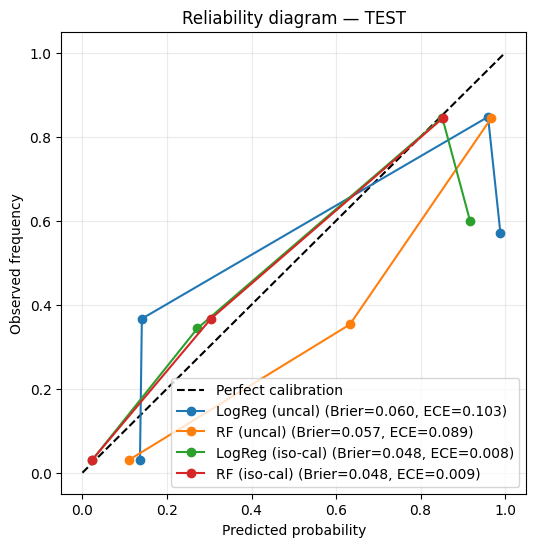

In [ ]:
# === Reliability diagram (calibration curve) on TEST ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Collect available test-set probability outputs
models = []
if 'log' in globals():     models.append(("LogReg (uncal)",    log.predict_proba(X_te)[:,1]))
if 'rf' in globals():      models.append(("RF (uncal)",        rf.predict_proba(X_te)[:,1]))
if 'cal_log' in globals(): models.append(("LogReg (iso-cal)",  cal_log.predict_proba(X_te)[:,1]))
if 'cal_rf' in globals():  models.append(("RF (iso-cal)",      cal_rf.predict_proba(X_te)[:,1]))
if not models and 'ACTIVE_CLF' in globals():
    models = [("Active model", ACTIVE_CLF.predict_proba(X_te)[:,1])]

# Simple Expected Calibration Error (ECE)
def ece(y_true, probs, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx  = np.digitize(probs, bins) - 1
    ece_val = 0.0
    for b in range(n_bins):
        m = (idx == b)
        if m.any():
            conf = probs[m].mean()
            acc  = y_true[m].mean()
            ece_val += m.mean() * abs(acc - conf)
    return ece_val

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],'k--',label='Perfect calibration')

for name, p in models:
    frac_pos, mean_pred = calibration_curve(y_te, p, n_bins=12, strategy='quantile')
    brier = brier_score_loss(y_te, p)
    ece10 = ece(y_te, p, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=f"{name} (Brier={brier:.3f}, ECE={ece10:.3f})")

plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability diagram — TEST")
plt.legend()
plt.grid(alpha=0.25)
plt.show()


In [ ]:
# === Bin counts (and observed rates) for the reliability diagram ===
import numpy as np, pandas as pd
from IPython.display import display

# Uses the same 'models' list and 'y_te' you defined in your reliability plot cell.
# Each item in 'models' is: (name, probs)
assert 'models' in globals() and 'y_te' in globals(), "Expected 'models' and 'y_te' in scope."

n_bins = 12                 # same as your calibration_curve call
use_common_bins = False     # set True to use shared bins for all models

def make_edges_quantile(p, n_bins):
    q = np.linspace(0, 1, n_bins + 1)
    edges = np.quantile(p, q)
    # clamp to [0,1] and ensure monotonicity
    edges[0], edges[-1] = 0.0, 1.0
    # Small safety for duplicate edges (heavy ties): jitter minimally
    for i in range(1, len(edges)):
        if edges[i] <= edges[i-1]:
            edges[i] = np.nextafter(edges[i-1], 1.0)
    return edges

# Optionally create common (pooled) bin edges
if use_common_bins:
    pooled = np.concatenate([p for _, p in models])
    common_edges = make_edges_quantile(pooled, n_bins)
else:
    common_edges = None

all_tables = []
for name, p in models:
    # Choose edges
    edges = common_edges if use_common_bins else make_edges_quantile(p, n_bins)
    # Assign bins
    idx = np.clip(np.digitize(p, edges, right=True) - 1, 0, len(edges) - 2)

    # Counts and observed rate
    counts = np.bincount(idx, minlength=len(edges) - 1)
    pos    = np.bincount(idx, weights=y_te, minlength=len(edges) - 1)
    with np.errstate(invalid="ignore", divide="ignore"):
        obs_rate = np.where(counts > 0, pos / counts, np.nan)

    # Mean predicted prob inside each bin (matches what your curve shows on x-axis)
    mean_pred = np.zeros_like(obs_rate, dtype=float)
    for b in range(len(counts)):
        m = (idx == b)
        mean_pred[b] = p[m].mean() if m.any() else np.nan

    # Bin labels
    bin_labels = [
        f"[{edges[i]:.2f},{edges[i+1]:.2f})" if i < len(edges)-2 else f"[{edges[i]:.2f},1.00]"
        for i in range(len(edges) - 1)
    ]

    tbl = pd.DataFrame({
        "model": name,
        "bin": bin_labels,
        "n_in_bin": counts,
        "mean_pred": np.round(mean_pred, 3),
        "obs_resistant_rate": np.round(obs_rate, 3),
    })
    all_tables.append(tbl)

result = pd.concat(all_tables, ignore_index=True)

print("Bin counts and observed rates (rows are probability bins).")
if use_common_bins:
    print("Note: common bin edges used across all models.")
else:
    print("Note: per-model quantile bins (match the plot’s strategy='quantile').")

display(result)


Bin counts and observed rates (rows are probability bins).
Note: per-model quantile bins (match the plot’s strategy='quantile').


,model,bin,n_in_bin,mean_pred,obs_resistant_rate
0,LogReg (uncal),"[0.00,0.14)",1898,0.136,0.030
1,LogReg (uncal),"[0.14,0.14)",0,NaN,NaN
2,LogReg (uncal),"[0.14,0.14)",0,NaN,NaN
3,LogReg (uncal),"[0.14,0.14)",0,NaN,NaN
4,LogReg (uncal),"[0.14,0.14)",0,NaN,NaN
5,LogReg (uncal),"[0.14,0.14)",0,NaN,NaN
6,LogReg (uncal),"[0.14,0.14)",0,NaN,NaN
7,LogReg (uncal),"[0.14,0.14)",0,NaN,NaN
8,LogReg (uncal),"[0.14,0.14)",0,NaN,NaN
9,LogReg (uncal),"[0.14,0.14)",30,0.141,0.367


### Interpreting the probability slider & choosing thresholds

**What the score means (after calibration).**  
For each isolate the model outputs a probability \(p = P(\text{levofloxacin resistant} \mid \text{QRDR features})\). Because we use **isotonic calibration**, these scores behave like true probabilities: isolates scored near 0.30 are resistant about 30% of the time in aggregate.

**Threshold \(t\) and predictions.**  
We predict **resistant** if \(p \ge t\), otherwise **susceptible**. The threshold is chosen based on use case:

- **Rule-out (prioritize sensitivity/recall):** choose a lower \(t\) (e.g., 0.15–0.25) to catch more resistant isolates, accepting more false positives.
- **Rule-in (prioritize precision/specificity):** choose a higher \(t\) (e.g., 0.60–0.80) to minimize false positives, accepting lower recall.

**Don’t confuse threshold with precision.**  
A threshold of 0.30 does not mean the model’s precision is 30%. Precision depends on the **distribution** of predicted probabilities and the **prevalence** of resistance. In our test set (prevalence ≈ 16%), \(t \approx 0.29\) yielded **Precision ≈ 0.84** and **Recall ≈ 0.81**.

**Why use Logistic Regression / RandomForest here (vs. MLP)?**  
Our QRDR features encode a **low-dimensional, mostly monotonic** signal (more QRDR mutation burden ⇒ higher risk). Simple models capture this well, are easier to calibrate, and generalize with minimal tuning. MLPs shine when there are **complex, high-dimensional interactions** (e.g., raw sequence data, whole-genome context) and enough data to learn them; otherwise they add complexity without clear gains.


------------------

**We built** a lightweight, clinically friendly predictor that turns simple gyrA/gyrB QRDR calls (from WGS, line-probe assay, or targeted sequencing) into a calibrated probability of levofloxacin resistance, with a slider to favor rule-out (high sensitivity) or rule-in (high precision).

**On 11,409** isolates it achieves **AUROC ≈ 0.92 and AUPRC ≈ 0.76** using only burden-style QRDR features

In [ ]:
# =========================
# Cell C — Predict helper + demos + tiny UI
# =========================
import io, numpy as np, pandas as pd

# --- Feature list used by your trained model(s) ---
FEATS = ['gyrA_burden','gyrB_burden','total_qrdr_burden','has_gyrB_520']

# --- Choose a model & threshold from your previous cells ---
# Prefer the calibrated logistic model; fall back to RF-cal or uncalibrated logistic if needed.
ACTIVE_CLF = None
for name in ["cal_log", "cal_rf", "log", "rf"]:
    if name in globals():
        ACTIVE_CLF = globals()[name]
        break
if ACTIVE_CLF is None:
    raise RuntimeError("No trained classifier found. Please run the training/calibration cells first.")

# Default threshold; replace with your F1-best threshold if you saved it earlier.
ACTIVE_THR = 0.50

# --- QRDR windows (AA positions) ---
QRDR = {
    "gyrA": (67, 106),   # includes 90/91/94
    "gyrB": (460, 550),  # includes 520 and 533–538
}

# --- column detection helpers ---
AA_POS_COLS = ["AMINO_ACID_NUMBER","AA_POS","AMINO_ACID_POS","amino_acid_number","Amino_acid_number"]
SAMPLE_COLS = ["UNIQUEID","sample","sample_id","ENA_SAMPLE"]

def detect_col(cols, candidates):
    low = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in low:
            return low[cand.lower()]
    return None

# --- compute burdens for ONE isolate (variants DataFrame for a single sample) ---
def compute_burden_from_variants(vars_one: pd.DataFrame) -> pd.Series:
    if vars_one.empty:
        return pd.Series(dict(
            gyrA_burden=0, gyrB_burden=0,
            total_qrdr_burden=0, has_gyrB_520=0
        ))

    gene_col = detect_col(vars_one.columns, ["GENE","gene"])
    aa_col   = detect_col(vars_one.columns, AA_POS_COLS)
    if gene_col is None or aa_col is None:
        raise ValueError("Input must contain GENE and an amino-acid position column "
                         "(e.g., AMINO_ACID_NUMBER).")

    v = vars_one.rename(columns={gene_col:"GENE", aa_col:"AA_POS"}).copy()
    # keep gyrA/gyrB rows with numeric AA positions
    v = v[(v["GENE"].isin(["gyrA","gyrB"])) & (v["AA_POS"].astype(str).str.isnumeric())]
    if v.empty:
        return pd.Series(dict(
            gyrA_burden=0, gyrB_burden=0,
            total_qrdr_burden=0, has_gyrB_520=0
        ))
    v["AA_POS"] = v["AA_POS"].astype(int)

    in_qrdr = (
        ( (v["GENE"]=="gyrA") & (v["AA_POS"].between(*QRDR["gyrA"])) ) |
        ( (v["GENE"]=="gyrB") & (v["AA_POS"].between(*QRDR["gyrB"])) )
    )
    q = v[in_qrdr]

    gyrA_burden = (q["GENE"]=="gyrA").sum()
    gyrB_burden = (q["GENE"]=="gyrB").sum()
    total_burden = len(q)
    has_gyrB_520 = int(((q["GENE"]=="gyrB") & (q["AA_POS"]==520)).any())

    return pd.Series(dict(
        gyrA_burden=gyrA_burden,
        gyrB_burden=gyrB_burden,
        total_qrdr_burden=total_burden,
        has_gyrB_520=has_gyrB_520
    ))

# --- score a whole table (possibly multiple samples) ---
def score_variants_table(variants_df: pd.DataFrame, clf=ACTIVE_CLF, thr=ACTIVE_THR):
    s_col = detect_col(variants_df.columns, SAMPLE_COLS)
    if s_col is None:
        # If no sample column, treat all rows as one isolate named 'sample_1'
        variants_df = variants_df.copy()
        variants_df["UNIQUEID"] = "sample_1"
        s_col = "UNIQUEID"

    out_rows = []
    for sid, sub in variants_df.groupby(s_col):
        feats = compute_burden_from_variants(sub)
        X = feats[FEATS].values.reshape(1,-1)
        p = float(clf.predict_proba(X)[:,1])
        label = int(p >= thr)
        out_rows.append(dict(sample_id=sid, **feats.to_dict(), prob=p, label_at_thr=label))
    return pd.DataFrame(out_rows)

# -------------------------
# Demos (synthetic but biologically realistic)
# -------------------------
# Demo 1: likely resistant (gyrA A90V + D94G)
demo_resistant = pd.DataFrame({
    "UNIQUEID": ["demoR","demoR"],
    "GENE": ["gyrA","gyrA"],
    "AMINO_ACID_NUMBER": [90, 94],
    "AMINO_ACID_CHANGE": ["A90V","D94G"]
})
known_label_demoR = 1  # expected resistant

# Demo 2: likely susceptible (no gyrA/B QRDR changes)
demo_susceptible = pd.DataFrame({
    "UNIQUEID": ["demoS"],
    "GENE": ["katG"],                       # outside our QRDR feature space
    "AMINO_ACID_NUMBER": [315],
    "AMINO_ACID_CHANGE": ["S315T"]
})
known_label_demoS = 0  # expected susceptible for FQ

# -------------------------
# Tiny UI: choose demo or upload CSV
# -------------------------
from IPython.display import display, Markdown
try:
    import ipywidgets as widgets

    instructions = """
**Predict helper — input format**

- CSV columns required:
  - `UNIQUEID` (or `sample` / `sample_id`) → sample identifier
  - `GENE` → gene name (e.g., gyrA, gyrB)
  - `AMINO_ACID_NUMBER` (or AA_POS variants) → amino-acid position (integer)
  - `AMINO_ACID_CHANGE` is optional; ignored by the model

- You can either:
  - Pick one of the built-in demos, **or**
  - Upload your own CSV (small tables are fine). Multiple samples allowed.
"""

    display(Markdown(instructions))

    demo_dd = widgets.Dropdown(
        options=[("— choose a demo —", ""),
                 ("Demo: likely resistant (gyrA A90V + D94G)", "R"),
                 ("Demo: likely susceptible (no QRDR changes)", "S")],
        description="Demo:",
        style={'description_width': 'initial'}, layout=widgets.Layout(width="70%")
    )
    upload = widgets.FileUpload(accept='.csv,.tsv', multiple=False)
    thr_slider = widgets.FloatSlider(value=ACTIVE_THR, min=0.05, max=0.95, step=0.01,
                                     description='Decision threshold', readout_format='.2f',
                                     style={'description_width': 'initial'}, continuous_update=False)
    btn = widgets.Button(description="Score", button_style='success')

    out = widgets.Output()

    def _on_score(_):
        out.clear_output()
        with out:
            # Select source
            use_demo = demo_dd.value in ("R","S")
            if use_demo:
                df_in = demo_resistant if demo_dd.value == "R" else demo_susceptible
                known = known_label_demoR if demo_dd.value == "R" else known_label_demoS
                print(f"[Demo] Using {'resistant' if known==1 else 'susceptible'} pattern.")
            else:
                if len(upload.value)==0:
                    print("Please upload a CSV or pick a demo.")
                    return
                name, up = list(upload.value.items())[0]
                content = io.BytesIO(up['content'])
                try:
                    df_in = pd.read_csv(content)
                except Exception:
                    content.seek(0)
                    df_in = pd.read_csv(content, sep='\t')
                known = None

            # Score
            res = score_variants_table(df_in, clf=ACTIVE_CLF, thr=thr_slider.value)
            display(res)

            # If demo with known label, show a quick check
            if known is not None and len(res)==1:
                pred = int(res['label_at_thr'].iloc[0])
                prob = float(res['prob'].iloc[0])
                msg = "✅ Matches expected label" if pred==known else "⚠️ Does NOT match expected label"
                print(f"\nKnown label={known} | Pred label={pred} @thr={thr_slider.value:.2f} | prob={prob:.3f} → {msg}")

            print("\nTip: Higher probability ⇒ more evidence for levofloxacin resistance. "
                  "Adjust the threshold for rule-in (↑precision) or rule-out (↑recall) use cases.")

    btn.on_click(_on_score)

    display(widgets.HBox([demo_dd]))
    display(widgets.HBox([widgets.Label("Or upload CSV:"), upload]))
    display(thr_slider)
    display(btn, out)

except Exception as e:
    # Fallback (no ipywidgets environment) — just run both demos programmatically
    print("[info] ipywidgets not available — running demos programmatically.\n")
    for name, dfi, known in [
        ("Demo resistant (A90V+D94G)", demo_resistant, known_label_demoR),
        ("Demo susceptible (no QRDR)", demo_susceptible, known_label_demoS)
    ]:
        print("==", name, "==")
        res = score_variants_table(dfi, clf=ACTIVE_CLF, thr=ACTIVE_THR)
        display(res)
        if len(res)==1:
            pred = int(res['label_at_thr'].iloc[0]); prob = float(res['prob'].iloc[0])
            msg = "✅ Matches expected" if pred==known else "⚠️ Mismatch"
            print(f"Known={known} | Pred={pred} | Prob={prob:.3f} @thr={ACTIVE_THR:.2f} → {msg}\n")



**Predict helper — input format**

- CSV columns required:
  - `UNIQUEID` (or `sample` / `sample_id`) → sample identifier
  - `GENE` → gene name (e.g., gyrA, gyrB)
  - `AMINO_ACID_NUMBER` (or AA_POS variants) → amino-acid position (integer)
  - `AMINO_ACID_CHANGE` is optional; ignored by the model

- You can either:
  - Pick one of the built-in demos, **or**
  - Upload your own CSV (small tables are fine). Multiple samples allowed.


FloatSlider(value=0.5, continuous_update=False, description='Decision threshold', max=0.95, min=0.05, step=0.0…

Button(button_style='success', description='Score', style=ButtonStyle())

Output()

**Next steps / Iterations**

- Codon-level features for gyrA(90/91/94) & gyrB(533–538, 520) to capture directionality (e.g., D94G vs D94A).

- Interaction terms (e.g., gyrA count × has_gyrB_520) to model synergy seen in some studies.

- Lineage-aware calibration / site-level recalibration so probabilities reflect local prevalence and MIC procedures.

- External validation on a held-out regional cohort; report decision-curve analysis for clinical utility.

- Package as a lightweight CLI/API (Docker/Streamlit) that accepts VCF or LPA outputs and returns probability + suggested threshold for rule-in or rule-out.

-------------------------------------------------

**Citations**

- CRyPTIC Consortium (2024). Large-scale genotype–phenotype mapping of Mtb drug resistance… (PMC11237524).

- This notebook’s model: QRDR-burden logistic / RF classifiers trained on CRyPTIC levofloxacin MICs (prevalence ≈0.16), calibrated with isotonic regression; test AUROC ≈0.92, AUPRC ≈0.76.

-------------------------------------------------

**One-paragraph "methods" README**

- We merged levofloxacin MIC/labels (ENA sample_id) with per-sample QRDR variant summaries derived from VARIANTS.csv.gz.

- From gyrA (AA 67–106) and gyrB (AA 460–550) we computed gyrA_burden, gyrB_burden, total_qrdr_burden, and has_gyrB_520.

- Missing variant rows were imputed as zero burden. We trained logistic regression and random-forest classifiers on an 80/20 stratified split, tuned the decision threshold by F1 on train, and reported AUROC/AUPRC, accuracy, precision, recall, and F1 on the held-out test.

- Probabilities were isotonic-calibrated on training folds.

- A compact predict helper maps new variant tables to features and outputs calibrated resistance probabilities with an adjustable clinical threshold.